<a href="https://colab.research.google.com/github/llucasmagoyel/Projeto-ImersaoIA-Google-Alura/blob/main/project_gemini_twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Como "burlar" a API do Gemini ? 😲**

Estudo de caso com uma empresa brasileira de Telefonia, utilizando as APIs do X (Twitter) e Gemini (Google) para verificar o sentimento dos clientes nas redes sociais em relação à empresa.

> ## Importação das bibliotecas necessárias


In [3]:
import google.generativeai as genai
from google.colab import userdata
import tweepy as tw
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import re

# Baixar as stopwords do NLTK
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

> ## Definição das chaves de acesso para a API do Twitter e do Gemini.

  Obs: As chaves do Twitter (X) devem ser obtidas registrando um aplicativo no Twitter Developer Platform: https://developer.twitter.com/, já as chaves do Gemini devem ser obtidas através do Google Ai Studio: https://aistudio.google.com/app/apikey
  

In [1]:
#Chaves de Acesso para a API do Twitter
consumer_key = userdata.get('consumer_key')
consumer_secret = userdata.get('consumer_secret')
access_token = userdata.get('access_token')
access_token_secret = userdata.get('access_token_secret')

#Chave de acesso para a API do Gemini
api_key = userdata.get('SECRET_KEY')

> ## Cria uma instância da API do Twitter usando a autenticação definida anteriormente.

    Obs: O parâmetro wait_on_rate_limit=True faz com que o Tweepy espere automaticamente quando atingir o limite de taxa da API.

In [64]:
# Cria uma instância de autenticação usando OAuth1UserHandler do Tweepy, passando as chaves de acesso.
auth = tw.OAuth1UserHandler(
    consumer_key, consumer_secret,
    access_token, access_token_secret
)

api = tw.API(auth, wait_on_rate_limit=True)

In [62]:
# Define a consulta de pesquisa (search) e o número máximo de tweets a serem coletados (qtd_tweets).
search = "@NomeDaEmpresa"
qtd_tweets = 100

> ## Coletar tweets usando o método search_tweets da API do Tweepy, passando a consulta de pesquisa e o número de tweets a serem coletados. Em seguida, cria um DataFrame do Pandas com o texto do tweet.

    Obs: Por conta da Lei Geral de proteção de Dados (LGPD), buscamos apenas o texto do tweet sem informar o nome do usuário.

In [ ]:
try:
    tweets = api.search_tweets(q=search, count=qtd_tweets)
    attributes_container = [[tweet.full_text] for tweet in tweets]
    columns = ["Tweet"]
    tweets_df = pd.DataFrame(attributes_container, columns=columns)
except BaseException as e:
    print('Status Failed On,',str(e) )

> ## Exibir e exportar os Tweets coletados

In [36]:
# Estamos removendo a menção da empresa nos tweets por questão de ética e para preservar sua imagem.
tweets_df = tweets_df.replace("NomeDaEmpresa", '', regex=True)

In [26]:
# Função para remover palavras que começam com '@'
def remove_mentions(text):
    return re.sub(r'@\w+', '', text)

# Aplicar a função ao DataFrame
tweets_df['Tweet'] = tweets_df['Tweet'].apply(remove_mentions)

In [37]:
# Configurando pandas para exibir o texto completo das células
pd.set_option('display.max_colwidth', None)

# Exibindo o DataFrame
tweets_df.head(100)

,Tweet
0,"Olá , bom dia! Informo que, aqui em casa, a imagem do canal 576 apresenta ligeiros travamentos, sendo que os outros canais estão normais. Vejam com a o que está acontecendo! Obrigado, ótimo dia! 🙏🙏"
1,Senhora queria saber porque meu Instagram não tá funcionando com o pacote de dados sendo que EU PAGUEI A CONTA. Obrigado
2,"ainda teve esse b.o aí KKKKKKK mas hj é um novo dia, dormi que nem bb"
3,me ajuda fia
4,faz 9 dias que a cortou minha linha por conta de 2 meses de atraso da minha fatura (q do nada deixou de ser débito…
...,...
95,Nunca deveria ter mudado minha internet para
96,"para contratar a internet de vocês eu preciso de um comprovante de endereço, quer dizer q preciso morar um mês sem internet p depois contratar já q estou me mudando agora?"
97,", agora , sempre prestou um serviço medíocre e caro.\nÉ um exemplo de que a máxima dos liberais, ""privatiza que o serviço melhora e fica mais barato"", não funciona."
98,O quase faz o terceiro na ! 👀\n\n#TôDentro | \n#CopaIntelbrasDoBrasil ://t.co…



> ## Usando a API do Gemini

  Obs: Realizado testes com os 2 métodos de Prompt (Structured Prompt e Freeform Prompt). Os código abaixo foram obtidos através do Google AI Studio gerado com "Get code"

In [38]:
#Cria uma instância da API do Gemini fornecendo a chave de acesso
genai.configure(api_key=api_key)

In [39]:
# Configuração do Modelo
generation_config = {
  "temperature": 1,
  "top_p": 0.95,
  "top_k": 0,
  "max_output_tokens": 8192,
}

safety_settings = [
  {
    "category": "HARM_CATEGORY_HARASSMENT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_HATE_SPEECH",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
]

### Método "Structured Prompt"

In [40]:
#Criação do Modelo com as configurações
model_struct = genai.GenerativeModel(model_name="gemini-1.0-pro",
                              generation_config=generation_config,
                              safety_settings=safety_settings)

In [41]:
#Função que estrutura como a resposta deve ser
def analise_sentimento_structured(tweet):

  #Estruturando como deve ser a resposta com base na entrada (inventando como deve ser um tweet)
  prompt_parts = [
    "input: Eu amo essa empresa, recomendo para todo mundo",
    "output: Positivo",
    "input: Odeio essa empresa, nada funciona como deveria ser",
    "output: Negativo",
    "input: Alguem sabe como faz isso ? preciso de ajuda",
    "output: Neutro",
    f"input: {tweet}",
    "output: "
  ]

  response = model_struct.generate_content(prompt_parts)
  return response.text

In [42]:
#Percorrendo o Dataframe para analisar cada twitter e salvar o resultado na coluna "Sentimentos"
tweets_df['sentimento_struc'] = tweets_df['Tweet'].apply(analise_sentimento_structured)

In [43]:
# Exibindo o DataFrame
tweets_df.head(100)

,Tweet,sentimento_struc
0,"Olá , bom dia! Informo que, aqui em casa, a imagem do canal 576 apresenta ligeiros travamentos, sendo que os outros canais estão normais. Vejam com a o que está acontecendo! Obrigado, ótimo dia! 🙏🙏",Negativo
1,Senhora queria saber porque meu Instagram não tá funcionando com o pacote de dados sendo que EU PAGUEI A CONTA. Obrigado,Negativo
2,"ainda teve esse b.o aí KKKKKKK mas hj é um novo dia, dormi que nem bb",Positivo
3,me ajuda fia,Neutro
4,faz 9 dias que a cortou minha linha por conta de 2 meses de atraso da minha fatura (q do nada deixou de ser débito…,Negativo
...,...,...
95,Nunca deveria ter mudado minha internet para,Negativo
96,"para contratar a internet de vocês eu preciso de um comprovante de endereço, quer dizer q preciso morar um mês sem internet p depois contratar já q estou me mudando agora?",Negativo
97,", agora , sempre prestou um serviço medíocre e caro.\nÉ um exemplo de que a máxima dos liberais, ""privatiza que o serviço melhora e fica mais barato"", não funciona.",Negativo
98,O quase faz o terceiro na ! 👀\n\n#TôDentro | \n#CopaIntelbrasDoBrasil ://t.co…,Neutro


### Método "Freeform Prompt"

  Obs: o método "Freeform" está disponível apenas na versão "gemini-1.5-pro-latest" mas a versão gratuita possui um número limitado de requisições por minuto conforme documentação: https://ai.google.dev/pricing?hl=pt-br

  A forma de "burlar" na verdade é utilizar o comando "time.sleep(30)" para realizar 2 requisições por minuto, já que estamos trabalhando com uma base de dados pequena (100 registros).

In [65]:
#Instrução de como deve ser a resposta e criação do Modelo
system_instruction = "Com base no texto que você irá receber, responda com apenas uma palavra, se o sentimento é Positivo, Negativo ou Neutro"

model_freeform = genai.GenerativeModel(model_name="gemini-1.5-pro-latest",
                              generation_config=generation_config,
                              system_instruction=system_instruction,
                              safety_settings=safety_settings)

In [66]:
#Função que recebe o texto e realiza a análise
import time
def analise_sentimento_freeform(tweet):

  response = model_freeform.generate_content(tweet)

  # Fazendo uma pausa de 30 segundos para não exceder a cota do "gemini-1.5-pro-latest (2 RPM)"
  time.sleep(30)

  return response.text.split()[0]

In [67]:
#Percorrendo o Dataframe para analisar cada twitter e salvar o resultado na coluna "Sentimentos"
tweets_df['sentimento_freeform'] = tweets_df['Tweet'].apply(analise_sentimento_freeform)

In [68]:
tweets_df.head(100)

,Tweet,sentimento_struc,sentimento_freeform
0,"Olá , bom dia! Informo que, aqui em casa, a imagem do canal 576 apresenta ligeiros travamentos, sendo que os outros canais estão normais. Vejam com a o que está acontecendo! Obrigado, ótimo dia! 🙏🙏",Negativo,Negativo
1,Senhora queria saber porque meu Instagram não tá funcionando com o pacote de dados sendo que EU PAGUEI A CONTA. Obrigado,Negativo,Negativo
2,"ainda teve esse b.o aí KKKKKKK mas hj é um novo dia, dormi que nem bb",Positivo,Positivo
3,me ajuda fia,Neutro,Neutro
4,faz 9 dias que a cortou minha linha por conta de 2 meses de atraso da minha fatura (q do nada deixou de ser débito…,Negativo,Negativo
...,...,...,...
95,Nunca deveria ter mudado minha internet para,Negativo,Negativo
96,"para contratar a internet de vocês eu preciso de um comprovante de endereço, quer dizer q preciso morar um mês sem internet p depois contratar já q estou me mudando agora?",Negativo,Negativo
97,", agora , sempre prestou um serviço medíocre e caro.\nÉ um exemplo de que a máxima dos liberais, ""privatiza que o serviço melhora e fica mais barato"", não funciona.",Negativo,Negativo
98,O quase faz o terceiro na ! 👀\n\n#TôDentro | \n#CopaIntelbrasDoBrasil ://t.co…,Neutro,Positivo


In [69]:
# Exportar o DataFrame com os Sentimentos para um arquivo Excel
tweets_df.to_excel("tweets_Sentimentos.xlsx", index=False)

> ## Analisando os Sentimentos

### Gráfico com a contagem de cada sentimento

In [59]:
# Contagem de sentimento
sentimento_count = tweets_df['sentimento_struc'].value_counts()

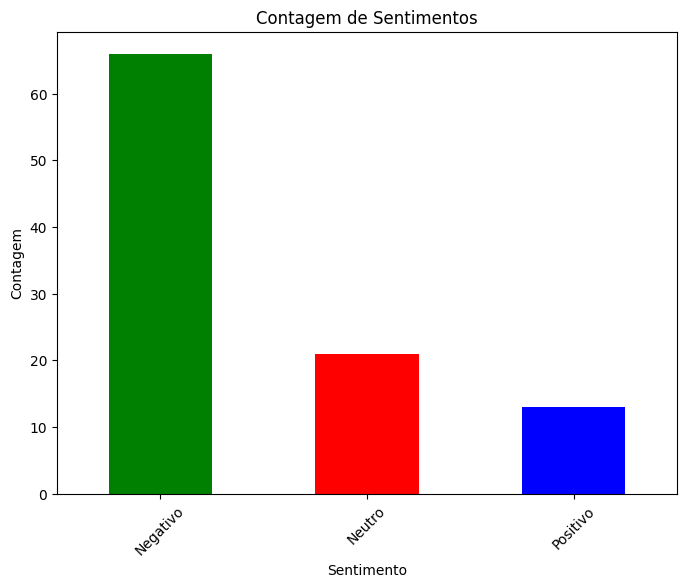

In [60]:
# Plot
plt.figure(figsize=(8, 6))
sentimento_count.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Contagem de Sentimentos')
plt.xlabel('Sentimento')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
plt.show()

### Nuvem de palavras

In [44]:
# Obter as stopwords em português
stopwords_pt = set(stopwords.words('portuguese'))

In [56]:
# Concatenando todos os tweets
texto = ' '.join(tweets_df['Tweet'])

In [57]:
# Remover as stopwords do texto
texto_sem_stopwords = ' '.join([word for word in texto.split() if word.lower() not in stopwords_pt])

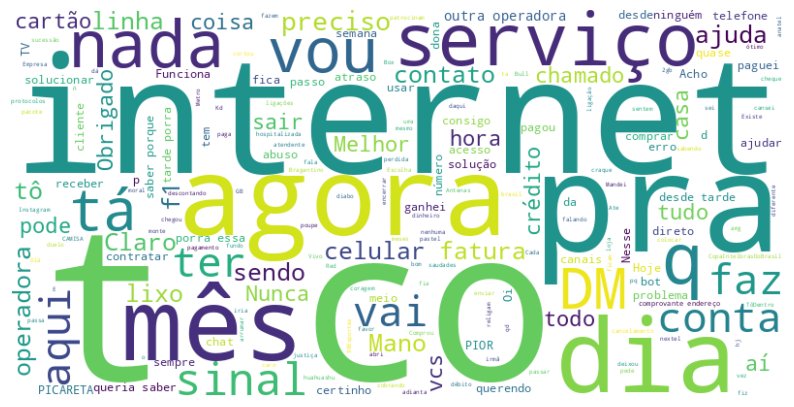

In [58]:
# Gerar a nuvem de palavras com o texto sem as stopwords
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_sem_stopwords)

# Plot
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Assuntos/Tópicos mais abordados

In [70]:
model = genai.GenerativeModel('gemini-pro')

In [80]:
response = model.generate_content(f"Analise esse conjunto de tweets sobre uma empresa e enumere os assuntos mais abordados (com a quantidade de tweets), sem mencionar o nome da empresa e nem o nome do produto: {texto} ")

In [81]:
print(f"{response.text}")

**Assuntos mais abordados:**

* **Problemas com internet (22)**
* **Atendimento ao cliente insatisfatório (12)**
* **Cobranças indevidas (5)**
* **Falta de sinal (5)**
* **Denúncias de práticas abusivas (3)**
* **Dificuldade em recuperar número de telefone após portabilidade (3)**
* **Cancelamento de serviços (2)**
* **Erros no aplicativo (1)**
* **Falha de segurança do Instagram (1)**


> ## Conclusão da Analise

In [82]:
conclusao = model.generate_content(f"Com base nesses assuntos mais comentados sobre uma determinada empresa, qual conclusão podemos tirar e o que deve ser feito ?: {texto} ")

In [84]:
print(conclusao.text)

**Conclusão:**

Os assuntos mais comentados sobre a empresa são relacionados a problemas técnicos, atendimento deficiente, cobranças indevidas e qualidade insatisfatória dos serviços.

**O que deve ser feito:**

* **Melhorar a qualidade da infraestrutura:** Investir em manutenção e modernização para minimizar problemas técnicos e garantir a estabilidade dos serviços.
* **Aprimorar o atendimento ao cliente:** Treinar e capacitar os atendentes para fornecer informações precisas e resoluções rápidas às reclamações.
* **Rever as políticas de cobrança:** Garantir transparência e evitar cobranças indevidas ou inesperadas.
* **Investir em inovação:** Desenvolver novos produtos e serviços para atender às demandas dos clientes e melhorar a experiência geral.
* **Monitorar e responder aos comentários dos clientes:** Criar canais para receber feedback e tomar medidas proativas para abordar as preocupações e melhorar a percepção da marca.
* **Considerar a concorrência:** Analisar as estratégias e 

> ## Final

Agora se você chegou nesse projeto pelo "Título", saiba que não existe 'jeitinho' para burlar a API, foi apenas um meio (mais lento) para conseguir mais requisições no modo gratuito da API.

Mas caso você possua uma volumetria maior de dados, o correto é contratar um pacote mais robusto do modelo "gemini-1.5-pro", que estará disponível para aquisição a partir do dia 14 de Maio de 2024, conforme site oficial.

[Preços para ajudar você a levar seu app ao mundo todo](https://ai.google.dev/pricing?hl=pt-br)



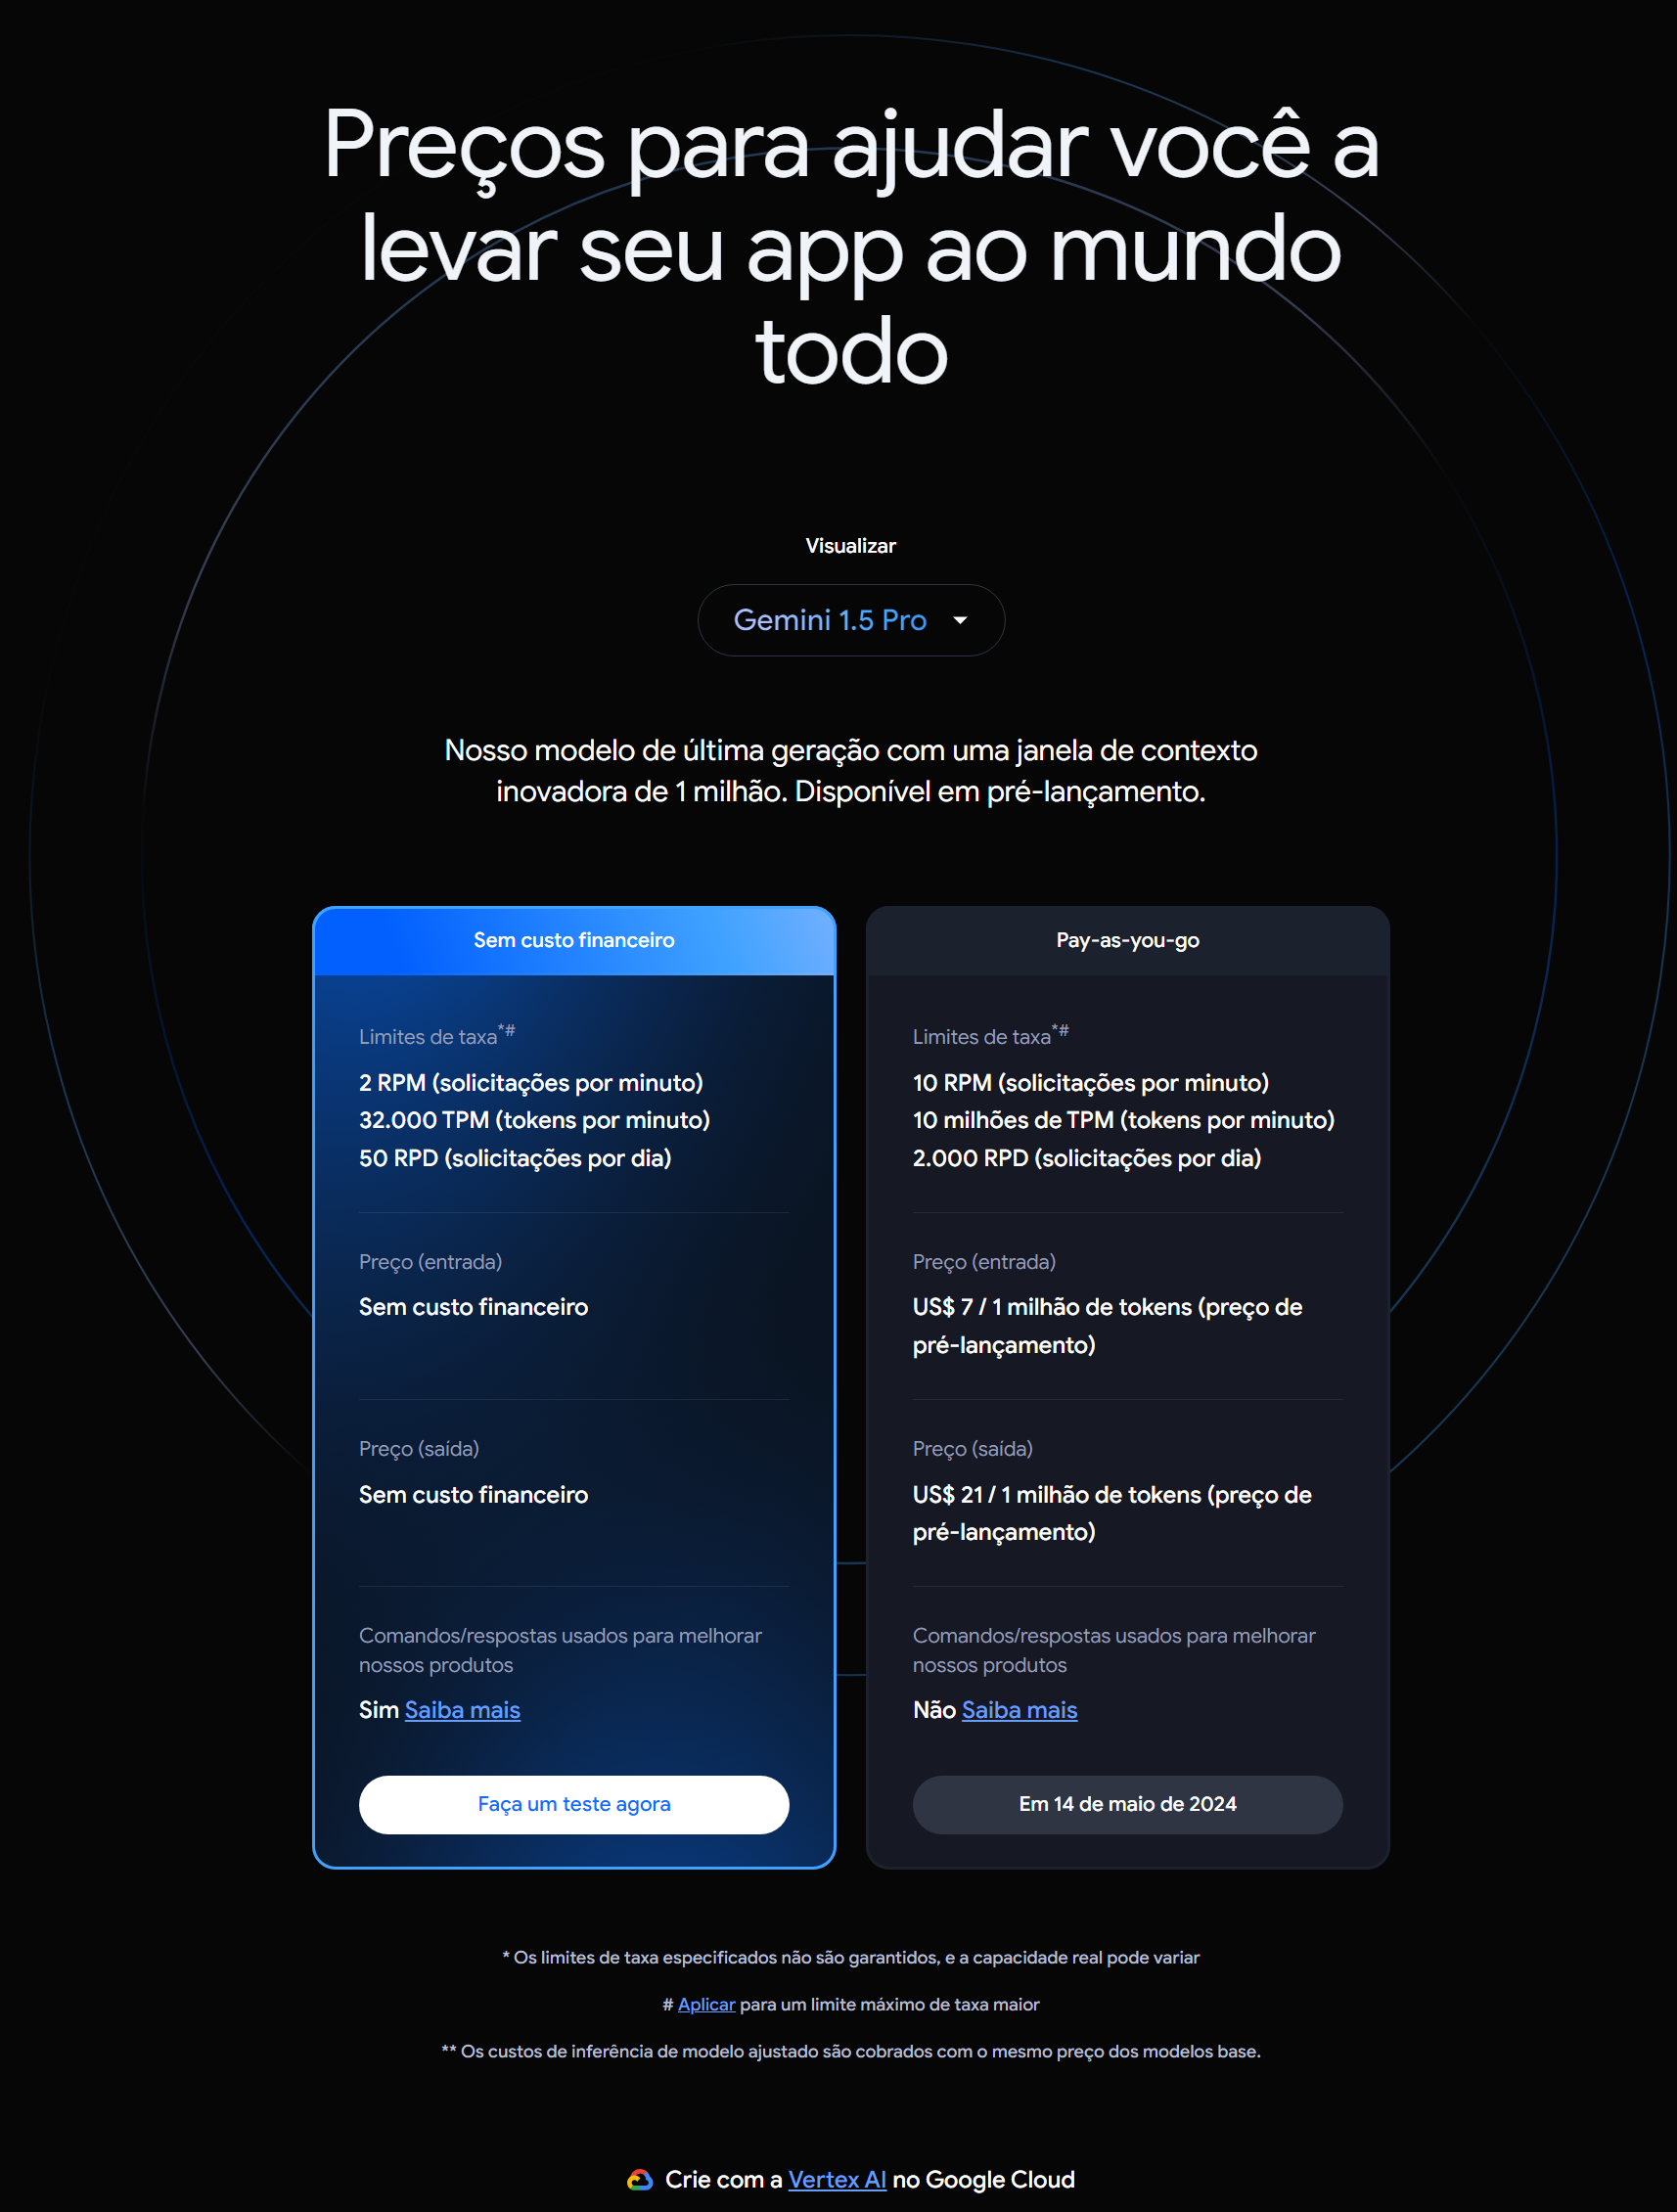